# Zoom grader

Loads zoom reports from a pre-defined folder, and calculates attendance.

Plan:

1. Load data from BIP
1. Process Zoom logs, ignore repetitions, summarize
1. Filter only one class
1. Read the actual list of students (separate for every class)
1. Use a substitutition table "name --> email" (separate file, one for all classes) to either substitute entries, or disable entries (special "command" for making it ignore an entry)
1. Using email as id, connect two databases. Output summary, as well as a list of failed entries (present on Zoom, but absent on BIP).

Piazza grader:

1. Load a list of Piazza people
2. Go through saved Piazza contributions, tabulate participation
3. Read attendance summary from part 1 (above)
4. Output a full table (screen & csv)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

In [2]:
folder_name = '../../data/attendance/'

In [3]:
# Read attendance data

df = pd.DataFrame()
file_list = os.listdir(folder_name)
print("Total files: ",len(file_list))

processed_list = set()
for fname in file_list:
    if fname[-3:]!='csv':
        continue # Ignore everything that is not a zoom log
    fullname = folder_name + fname
    header = pd.read_csv(fullname, header=0, nrows=1) # Attempt to read the header
    if 'Topic' not in header.columns: # Not a zoom log, skip this one
        continue
    name = header['Topic'][0]    
    datestring = header['Start Time'][0][:10]
    # print(name, datestring)
    if name+datestring in processed_list:
        print('Duplicated meeting:', name+datestring, fname)
        continue  # This meeting
    processed_list.add(name+datestring)
    
    data = pd.read_csv(fullname, header=2)
    data['Date'] = datestring
    data['Meeting'] = name
    data['User Email'] = data['User Email'].fillna('none') # NaNs are ignored by aggregation below
    
    df = df.append(data, ignore_index=True)

print('Meeting files:', len(processed_list))

Total files:  17
Meeting files: 14


In [4]:
# Rename fields, standardize meetings that had synonyms

df= df.rename({'User Email': 'email', 
               'Total Duration (Minutes)': 'minutes', 
               'Name (Original Name)': 'name',
               'Meeting':'meeting',
               'Date':'date'}, axis=1)
meeting_dict = {'Biosem Zoom': 'Biosem', 
                'Biosem_spring_2021': 'Biosem',
                'Neuroscience': 'Neuro'}
df['meeting'] = df['meeting'].replace(meeting_dict)
df.name = df.name.str.title()  # Capitalize names (for consistency)

In [5]:
# Inexplicably, some total participation counts are stored as strings, not numbers

df.loc[df.minutes=='Yes'] = 0 # No idea what it means, but Zoom outputed it!!!
ind = [type(a)!=int for a in df.minutes.values]
df.loc[ind, 'minutes'] = [int(a) for a in df.loc[ind].minutes.values]
df = df[df.minutes>0]  # Remove weird empty entries

# df['check'] = 1*(df.minutes>40) # Simple attendance
df['check'] = 0.3*(df.minutes>30) + 0.7*(df.minutes>50) # Full attendance and late classes

In [6]:
# What meetings are even there?
set(df.meeting)

{'Biosem', 'Computational Neuro', 'Neuro'}

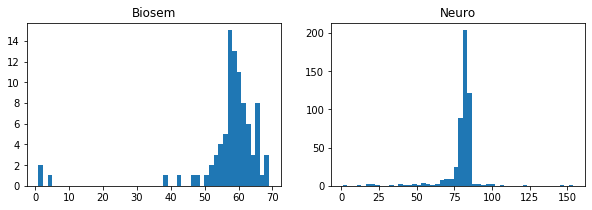

In [7]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(df.loc[df.meeting=='Biosem'].minutes.values, bins=50);
plt.title('Biosem');
plt.subplot(122)
plt.hist(df.loc[df.meeting=='Neuro'].minutes.values, bins=50);
plt.title('Neuro');

In [8]:
# Only analyze one meeting starting from here

target_meeting = 'Neuro'

df = df[df.meeting=='Neuro']

In [9]:
# Check individual records of needed
# df.loc[df.name.str[:3]=='Fen']

In [10]:
# Read the actual list of students. Note that the file name needs to match the meeting name.

people = pd.read_csv(folder_name + target_meeting + '.csv', header=0, sep=',')
people.columns = [' '.join(s.split()) for s in people.columns] # Remove repeating spaces, just in case
# print(people.columns)
people['name'] = people['FIRST NAME'] + ' ' + people['LAST NAME']
people = (people
          .drop_duplicates() # A left-over from the "All meetings at once" pipeline, but let's keep for a while
          .reset_index()
          .rename({'ID#':'id', 'Email': 'email'}, axis=1)
          .loc[:,['id', 'email', 'name']]
         )
print(people.columns)
# people.head()

Index(['id', 'email', 'name'], dtype='object')


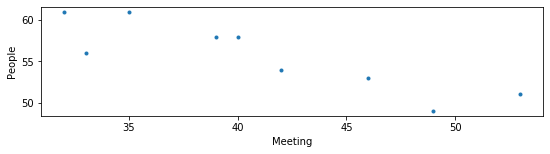

In [11]:
# Troubleshooting: A full list of meetings with their attendance.
# Check if the plot makes sense.

dfm = df.groupby(['date','meeting','name']).agg({'minutes': sum})
dfm.minutes = 1*(dfm.minutes>10)
dfm = dfm.groupby(['date', 'meeting']).agg({'minutes': sum}).reset_index()
dfm = dfm.rename({'minutes':'people'}, axis=1)
dfm.date = pd.to_datetime(dfm.date)

plt.figure(figsize=(9,2))
plt.plot(dfm.date.dt.dayofyear, dfm.people, '.');
plt.xlabel('Meeting');
plt.ylabel('People');

# print(dfm)

In [12]:
# Check if there are any entries without email at all

# df[[len(a)<10 for a in df.email]]

In [13]:
# Find people with emails that aren't on the official list
# Output them, to manually create a list of alt-emails.

df_lost = (df           
           .groupby(['name','email'])
           .agg({'minutes': sum})
           .reset_index()
           .merge(people, on='email', how='left', suffixes=['', '_r']) # Ignore official name (_r)
           .drop(columns='name_r')           
           #.query('id != id') # A hack to filter out non-numebers. It works, but it's a hack
           .query('id.isna()', engine='python') # Official way
          )
print('Rows found:', len(df_lost.id))
#print('\n'.join([a for a in df_lost['name'] + ',' + df_lost['email']])) # Output csv
# df_lost # Output nice human-readable form

Rows found: 21


In [14]:
# Read and process known alts

df_alts = pd.read_csv(folder_name + 'alts.csv', header=0, sep=',')

# First find official emails where available, and drop some users manually (e.g. the instructor)
df_fixed = (df
            .merge(df_alts, on='email', how='left', suffixes=['', '_r'])
            .drop(columns=['name_r'])
            .query("real_email != 'none'")
           )

# Substitute 'wrong' emails with 'official' emails where available
ind = (df_fixed.real_email.notna())
df_fixed.loc[ind, 'email'] = df_fixed.loc[ind, 'real_email']
df_fixed = df_fixed.drop(columns='real_email')

# Lookup correct names, and drop all users who are not on bip
df_fixed = (df_fixed
            .merge(people, on='email', how='left', suffixes=['_l', '']) # This time keep official names only
            .drop(columns=['name_l', 'id', 'Guest'])
            .query('name.notna()', engine='python') # Drop people who are not on bip
           )

# df_fixed

In [22]:
# Build a summary

dfs = (df_fixed
       .groupby(['name','email'])
       .agg({'check': sum})
       .reset_index()
      )

# dfs.sort_values(by='check')
# dfs

# Part 2: Piazza grader

In [86]:
# Read all students enrolled on Piazza, with their Piazza names
# Here make sure the list has only 1 email, and this email is correct. Some people like to include
# more than one email for some reason...

people_piazza = pd.DataFrame(columns=['name', 'email'])
lines = open(folder_name + 'Piazza.list', 'r', encoding='utf-8').readlines()
for line in lines:
    l = line.strip().split(' ')
    email = l[-1]
    name = ' '.join(l[:-1])
    if name != '': # Ignore unregistered users
        people_piazza = people_piazza.append({'name': name, 'email': email}, ignore_index=True)
        
# people_piazza

In [87]:
# Read all piazza pages. All of them should be saved as txt files.
# NOTE: There's no safety check on the content of TXT files, so no other TXT files are allowed in this folder!

df_piazza = pd.DataFrame(columns=['name','work'])
file_list = os.listdir(folder_name)
for fname in file_list:
    if fname[-3:]!='txt':
        continue # Ignore everything that is not a zoom log    
    s = open(folder_name + fname, 'r', encoding='utf-8').read()
    title = s[:s.find('\n')]
    print(fname, ':', title)
    for name in people_piazza.name:
        if name in s:
            df_piazza = df_piazza.append({'name': name, 'work':title}, ignore_index=True)

1.txt : Week 1: Intro & Resting membrane potential
2.txt : Week 2: action potential
3.txt : Week 3: Synapses, Connectomics, some Free Will
4.txt : Week 4: Ethology, Inhibition, Integration
lab2.txt : Lab 2: Eyewire


In [88]:
# Now summarize, then merge left on the full list of people

dfsp = (df_piazza        
        .groupby(['name'])
        .agg('count')
        .reset_index()
       )
dfsp = (people_piazza
        .merge(dfsp, on='name', how='left')
       )
dfsp.loc[dfsp.work.isna(),'work'] = 0
dfsp.work = dfsp.work.astype(int)

# dfsp

In [108]:
# Full output

df_full = dfsp.merge(dfs, on='email', suffixes=['_piazza','_zoom'])
with pd.option_context('display.max_rows', 14000, 'display.width', 1000):
    # print(df_full)
    pass

In [122]:
# How many missed assignments are problematic?

print('Can miss classes, and still pass:', 0.2*34)
print('Can miss classes, and still get a B:', 0.1*34)
print('Can miss homeworks, and still pass:', 0.2*21)
print('Can miss homeworks, and still get a B:', 0.1*21)

Can miss classes, and still pass: 6.800000000000001
Can miss classes, and still get a B: 3.4000000000000004
Can miss homeworks, and still pass: 4.2
Can miss homeworks, and still get a B: 2.1


In [123]:
# At-risk students

classes_so_far = 9
works_so_far = 5
df_at_risk = df_full.query('work < @works_so_far-1 | check < @classes_so_far-3')

#print(','.join([e for e in df_at_risk.email]))
#df_at_risk

In [18]:
# Ouput the summary csv
#recognized.to_csv(folder_name + '../attendance_summary.csv', index=False)

In [19]:
# print('\n'.join(df2.loc[df2.meeting=="Neuro"].sort_values(by='name').name.tolist()))

In [20]:
# df2.loc[df2.meeting=='Neuro'].sort_values(by='name').drop(columns=['meeting', 'email'])